In [1]:
import scipy as sci
import matplotlib.pyplot as plt
import wfdb
import pandas as pd
%matplotlib inline

# Single Record Data Generation
Bootstrapping is used to sample arrhythmia-labelled windows around r-peak labels in the MIT-BIH dataset.

In [263]:
data_dir = 'MIT-BIH-Arrhythmia/'
record = '103'
ext = 'atr'

annot = wfdb.rdann(data_dir+record,ext)
annot_str = pd.DataFrame({'index':annot.sample,'sym':annot.symbol})
print(annot_str['sym'].value_counts())

data = wfdb.rdsamp(data_dir + record)
data_str = pd.DataFrame({'channel1':data[0][:,0],'channel2':data[0][:,1]})

N    2082
~       6
A       2
+       1
Name: sym, dtype: int64


In [229]:
# Generate ad hoc dataset of "heartbeats"
normal = sci.where(annot_str['sym'] == 'N')[0]
pvc = sci.where(annot_str['sym'] == 'V')[0]
fusion = sci.where(annot_str['sym'] == 'F')[0]

normal_ind = annot_str['index'][normal]
pvc_ind = annot_str['index'][pvc]
fusion_ind = annot_str['index'][fusion]

w = 100
nover2 = 100 # Number of sample points from each bin

X_train = []
y_train = []

X_test = []
y_test = []

for i in range(nover2):
    # normal beat
    ind = sci.random.choice(normal_ind) # sample for training
    normal_window_train = sci.array(data_str['channel1'])[(ind-w):(ind+w)]
 
    ind = sci.random.choice(normal_ind) # sample for testing
    normal_window_test = sci.array(data_str['channel1'])[(ind-w):(ind+w)]

    # pvc beat
    ind = sci.random.choice(pvc_ind) # sample for training
    pvc_window_train = sci.array(data_str['channel1'])[(ind-w):(ind+w)]
 
    ind = sci.random.choice(pvc_ind) # sample for testing
    n_pvc_window_test = sci.array(data_str['channel1'])[(ind-w):(ind+w)]

    # fusion beat
    ind = sci.random.choice(fusion_ind) # sample for training
    fusion_window_train = sci.array(data_str['channel1'])[(ind-w):(ind+w)]
 
    ind = sci.random.choice(fusion_ind) # sample for testing
    fusion_window_test = sci.array(data_str['channel1'])[(ind-w):(ind+w)]

    if (len(normal_window_train) != 2*w   or 
        len(normal_window_test) != 2*w or 
        len(pvc_window_train) != 2*w  or 
        len(pvc_window_test) != 2*w or
        len(fusion_window_train) != 2*w or
        len(fusion_window_test) != 2*w):
        continue

    X_train.append(normal_window_train)
    X_train.append(pvc_window_train)
    X_train.append(fusion_window_train)

    X_test.append(normal_window_test)
    X_test.append(pvc_window_test)
    X_test.append(fusion_window_test)

    y_train.append(0)
    y_train.append(1)
    y_train.append(2)

    y_test.append(0)
    y_test.append(1)
    y_test.append(2)

In [230]:
label_dict = {0: 'Normal', 1: 'PVC', 2: 'Fusion'}

X_train = sci.array(X_train)
y_train = sci.array(y_train)

X_test = sci.array(X_test)
y_test = sci.array(y_test)

In [231]:
print(X_train.shape)
print(X_test.shape)

(300, 200)
(300, 200)


# Single Record Heartbeat Visualization

In [232]:
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from sklearn.manifold import Isomap
from sklearn.manifold import LocallyLinearEmbedding

vis_tsne = TSNE(random_state=354723)
vis_tsne.fit(X_train)

TSNE(angle=0.5, early_exaggeration=12.0, init='random', learning_rate=200.0,
   method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
   n_components=2, n_iter=1000, n_iter_without_progress=300,
   perplexity=30.0, random_state=354723, verbose=0)

In [233]:
vis_mds = MDS()
vis_mds.fit(X_train)

MDS(dissimilarity='euclidean', eps=0.001, max_iter=300, metric=True,
  n_components=2, n_init=4, n_jobs=1, random_state=None, verbose=0)

In [234]:
vis_iso = Isomap()
vis_iso.fit(X_train)

Isomap(eigen_solver='auto', max_iter=None, n_components=2, n_jobs=1,
    n_neighbors=5, neighbors_algorithm='auto', path_method='auto', tol=0)

In [235]:
vis_lle = LocallyLinearEmbedding()
vis_lle.fit(X_train)

LocallyLinearEmbedding(eigen_solver='auto', hessian_tol=0.0001, max_iter=100,
            method='standard', modified_tol=1e-12, n_components=2,
            n_jobs=1, n_neighbors=5, neighbors_algorithm='auto',
            random_state=None, reg=0.001, tol=1e-06)

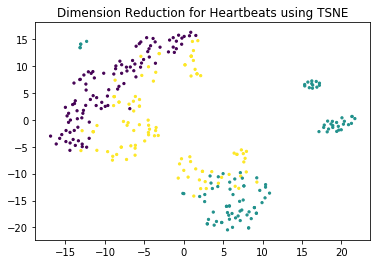

In [259]:
sc = plt.scatter(x=vis_tsne.embedding_[:,0], y=vis_tsne.embedding_[:,1], c=y_train, s=5)

plt.title('Dimension Reduction for Heartbeats using TSNE')
#plt.savefig('tsne_heartbeats.png', dpi=400)

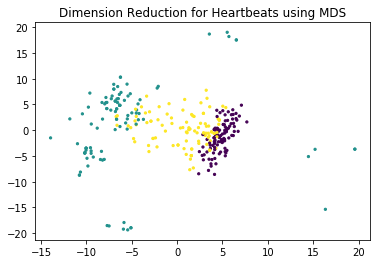

In [237]:
sc = plt.scatter(x=vis_mds.embedding_[:,0], y=vis_mds.embedding_[:,1], c=y_train, s=5)
plt.title('Dimension Reduction for Heartbeats using MDS')

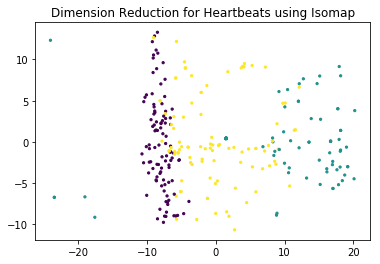

In [238]:
sc = plt.scatter(x=vis_iso.embedding_[:,0], y=vis_iso.embedding_[:,1], c=y_train, s=5)
plt.title('Dimension Reduction for Heartbeats using Isomap')

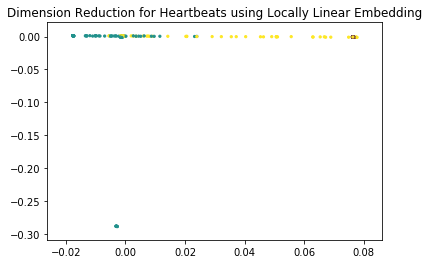

In [239]:
sc = plt.scatter(x=vis_lle.embedding_[:,0], y=vis_lle.embedding_[:,1], c=y_train, s=5)
plt.title('Dimension Reduction for Heartbeats using Locally Linear Embedding')

# Single Record Heartbeat Classification

In [240]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

In [241]:
svm = SVC(probability=True)
svm.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [257]:
thresh = 0.5
prob = svm.predict_proba(X_train)
pred = [label_dict[sci.argmax(p)] for p in prob]
y_train_label = [label_dict[i] for i in y_train]

print('In-sample performance:')
print(confusion_matrix(y_train_label, pred))
print(classification_report(y_train_label, pred))

In-sample performance:
[[84  9  7]
 [ 4 96  0]
 [ 6  0 94]]
             precision    recall  f1-score   support

     Fusion       0.89      0.84      0.87       100
     Normal       0.91      0.96      0.94       100
        PVC       0.93      0.94      0.94       100

avg / total       0.91      0.91      0.91       300



In [ ]:
thresh = 0.5
prob = svm.predict_proba(X_test)[:,0]
pred = prob < 0.5

print('Out-of-sample performance:')
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

# Generalization to new patients